# Step 1: Preparation
## 1 ETL
### 1.1 读取数据

In [2]:
# 导入modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.font_manager import FontProperties
font_set = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)

In [3]:
from IPython.core.display import display
os.listdir('../data')
df_raw = pd.read_csv('../data/data.csv', encoding='ISO-8859-1', dtype={'CustomerID': str, 'InvoiceID': str})
df_raw["InvoiceDate"] = pd.to_datetime(df_raw["InvoiceDate"])

print("DataFrame Shape: ", df_raw.shape)

DataFrame Shape:  (541909, 8)


In [4]:
df_raw.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


这里对每个变量做一些解释：
*InvoiceNo*: 每一笔订单的单号.
*StockCode*: 订单中的一种商品编号
*Description*: 对这种商品的描述
*Quantity*: 在这一订单中这种商品的数量
*InvoiceDate*: 每笔订单的发生时间
*UnitPrice*: 该商品的单价
*CustomerID*: 购买者的用户ID
*Country*: 购买用户的国家

### 1.2 数据清洗
#### 1.2.1 数据缺失

In [5]:
# 缺失数据数量统计
df_raw.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# 缺失数据占比
pd.DataFrame(df_raw.isnull().sum()) / df_raw.shape[0] * 100

,0
InvoiceNo,0.000000
StockCode,0.000000
Description,0.268311
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,24.926694
Country,0.000000


Note: 观测到这里缺失的顾客ID信息占比近25%！思考这缺失的原因：可能是在该网站上买东西时不需要强制登陆。但我们可以假设这25%不是由那75%的用户产生的（实际中一般有账号的用户买东西时都会登陆），这样不同的用户之间可以看作是独立的，我们就直接删去这些缺失数据！

In [7]:
df_raw.dropna(axis=0, inplace=True)

In [8]:
df_raw.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

删去空的CustomerID的数据后，已经没有空值了。

#### 1.2.2 异常数据

In [9]:
# 先看InvoiceNo
df_raw["InvoiceNo"].value_counts().iloc[0:20]

576339    542
579196    533
580727    529
578270    442
573576    435
567656    421
567183    399
575607    377
571441    364
570488    353
572552    352
568346    335
547063    294
569246    285
562031    277
554098    264
543040    259
570672    259
569897    239
572103    223
Name: InvoiceNo, dtype: int64

In [10]:
# 观察InvoiceNo的长度
df_raw["InvoiceNo"].apply(lambda l: len(l)).value_counts()
# 发现还有7位的，接下来仔细看一下

6    397924
7      8905
Name: InvoiceNo, dtype: int64

In [11]:
long_invoice_no = df_raw[df_raw["InvoiceNo"].apply(lambda l: len(l)) != 6]
long_invoice_no.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Note: 发现C开头的订单都是退货的信息，这不是我们目前想要深入了解的，目前我们先专注于购买订单，因此把这里的8905条退货数据删除。

In [12]:
df_cleaned = df_raw.loc[df_raw["InvoiceNo"].apply(lambda l: l[0] != 'C')]

df_cleaned.shape[0]

397924

In [13]:
# 接下来看StockCode
df_cleaned["StockCode"].value_counts()
# 并没有看出什么不对，再看一下长度

85123A    2035
22423     1724
85099B    1618
84879     1408
47566     1397
          ... 
90177E       1
84877A       1
90039C       1
90176C       1
90100        1
Name: StockCode, Length: 3665, dtype: int64

In [14]:
df_cleaned["StockCode"].apply(lambda l: len(l)).value_counts()
# 发现有多种长度的StockCode, 最长的长达12

5     363119
6      32960
4       1103
7        291
1        290
2        133
3         16
12        12
Name: StockCode, dtype: int64

In [15]:
StockCode_length = df_cleaned["StockCode"].apply(lambda l: len(l))
display(df_cleaned[StockCode_length == 1].head(3))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274,United Kingdom
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274,United Kingdom
6798,536981,M,Manual,2,2010-12-03 14:26:00,0.85,14723,United Kingdom


In [16]:
# 观测特殊StockCode的Description情况
for i in [1,2,3,4,12]:
    print(df_cleaned[StockCode_length == i].Description.value_counts())

Manual    290
Name: Description, dtype: int64
CARRIAGE    133
Name: Description, dtype: int64
DOTCOM POSTAGE    16
Name: Description, dtype: int64
POSTAGE                       1099
PADS TO MATCH ALL CUSHIONS       4
Name: Description, dtype: int64
Bank Charges    12
Name: Description, dtype: int64


Note: 发现当StockCode为1、2、3、4、12时Description分别为Manual、CARRIAGE、DOTCOM POSTAGE、POSTAGE、Bank Charges。这些运费等附加费用不是我们的主要盈利来源，所以我们先不需要这些信息，一并删除。

In [17]:
df_cleaned = df_cleaned[df_cleaned["StockCode"].apply(lambda l: len(l) in [5,6,7])]

In [18]:
# 再看CustomerID
df_cleaned.CustomerID.value_counts()

17841    7838
14911    5591
14096    5095
12748    4580
14606    2697
         ... 
17747       1
18174       1
18184       1
18268       1
16257       1
Name: CustomerID, Length: 4335, dtype: int64

In [19]:
df_cleaned.CustomerID.apply(lambda l: len(l)).value_counts()
# 看上去都正常

5    396370
Name: CustomerID, dtype: int64

In [20]:
# 再看Quantity
display(df_cleaned.Quantity.describe())
# 发现极大值是异常点

count    396370.000000
mean         13.046474
std         180.733597
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

In [21]:
quantity_high = np.quantile(df_cleaned.Quantity, 0.99)
print("99%的商品数量控制在(1, {})之间".format(quantity_high))

99%的商品数量控制在(1, 120.0)之间


Note: 由于Quantity最大值为80995，但百分之99的商品数量在1到120之间，难免让人觉得这些量大的订单是极少数情况。而且我们预测的是大多数用户的购买行为，针对这些极少数情况的数据没有什么利用价值。因此把1-120外的数据删除，留下99%的数据。

In [22]:
df_cleaned = df_cleaned.loc[(df_cleaned.Quantity <= 120)]

df_cleaned.shape[0]

392481

In [23]:
# 再看UnitPrice
display(df_cleaned.UnitPrice.describe())
# 发现居然单价最小值有0

UnitPrice_high = np.quantile(df_cleaned.UnitPrice, 0.99)
UnitPrice_low = np.quantile(df_cleaned.UnitPrice, 0.01)
print("98%的数据在", (UnitPrice_low, UnitPrice_high), "中")
# 发现极大值太大

count    392481.000000
mean          2.883001
std           4.280902
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

98%的数据在 (0.29, 12.75) 中


In [24]:
price_notzero = df_cleaned[df_cleaned.UnitPrice != 0]["StockCode"].unique()
price_zero = pd.DataFrame(df_cleaned[df_cleaned.UnitPrice == 0]["StockCode"])
price_zero["NewOrNot"] = price_zero["StockCode"].apply(lambda l: l not in price_notzero)
display(price_zero.T)
# 发现单价为0的商品并不是第一次出现，是否可以借鉴同商品的单价？

,9302,33576,40089,47068,47070,56674,86789,130188,139453,145208,...,420404,436597,439361,446125,446793,446794,454463,454464,479079,480649
StockCode,22841,22580,22423,22090,22553,22168,84535B,22062,22055,22162,...,21208,22065,22385,22625,22899,23480,22437,22089,22464,23407
NewOrNot,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
print(df_cleaned[df_cleaned.StockCode == "22841"]["UnitPrice"].value_counts())
# 发现同商品有多个价格

7.95     187
6.95       9
15.79      2
5.49       2
0.00       1
Name: UnitPrice, dtype: int64


Note: 通过分析单价我们发现，单价为0的商品有其他多个价格，因此我们不能直接替换成其他任意价格，或许为0的价格是因为作为附加的礼品赠送的，因此这不是我们盈利的来源，我们把这些数据也删除。

In [26]:
high_price_commerce = df_cleaned[df_cleaned.UnitPrice > 150].StockCode.unique()
display(high_price_commerce)

array(['22827', '22655', '22828', '22826', '22656', '22502'], dtype=object)

In [27]:
display(df_cleaned[df_cleaned["StockCode"].map(lambda l: l in high_price_commerce)].groupby(["StockCode", "UnitPrice"])["Quantity"].agg(["sum", "count"]))

display(df_cleaned[(df_cleaned["StockCode"] == "22502") & (df_cleaned["UnitPrice"] - 649.50 == 0)])

sum  count
StockCode UnitPrice            
22502     2.00         1      1
          4.95       740     29
          5.95       686    207
          649.50      61      2
22655     50.00        3      2
          125.00      52     31
          295.00       5      5
22656     50.00        1      1
          125.00      22     16
          295.00       3      3
22826     85.00       46     30
          175.00       2      1
          195.00      10     10
22827     145.00      18      9
          165.00      17     17
22828     145.00       6      3
          165.00       4      4

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098,United Kingdom
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098,United Kingdom


Note: 看似除了StockCode为22502的商品其他商品单价都很合理。商品22502的单价649.50和它其他的单价相差大，这里这两个订单信息也属于极少数情况，对我们预测大多数用户购买行为没有什么帮助，因此删去。

In [28]:
df_cleaned = df_cleaned.loc[df_cleaned["UnitPrice"] < 500]

In [29]:
df_cleaned.shape[0]

392479

In [30]:
# 对于InvoiceDate
df_cleaned["InvoiceDate"].describe()
# 挺合理的，时间的跨度是12个月

c:\users\edwin\anaconda3\envs\e-commerce data\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                  392479
unique                  16833
top       2011-11-14 15:27:00
freq                      541
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [31]:
# 对于country
country_info = pd.DataFrame(df_cleaned.Country.value_counts()).rename(columns={"Country": "Total"})
country_info["Rate"] = (country_info["Total"].map(lambda l: round(l/ df_cleaned.shape[0] * 100, 2)))

display(country_info.sort_values(by="Rate", ascending=False).iloc[0:10])

,Total,Rate
United Kingdom,351257,89.50
Germany,8618,2.20
France,8005,2.04
EIRE,6956,1.77
Spain,2404,0.61
Belgium,1932,0.49
Netherlands,1840,0.47
Switzerland,1808,0.46
Portugal,1425,0.36
Norway,1043,0.27


Note: 可以看到接近90%的数据来自英国。

In [32]:
# 最后我们查看Description
df_cleaned["Description"].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    1991
REGENCY CAKESTAND 3 TIER              1717
JUMBO BAG RED RETROSPOT               1560
PARTY BUNTING                         1385
ASSORTED COLOUR BIRD ORNAMENT         1355
                                      ... 
GLASS BEAD HOOP EARRINGS AMETHYST        1
LETTER "O" BLING KEY RING                1
WALL ART,ONLY ONE PERSON                 1
FLOWER SHOP DESIGN MUG                   1
PINK PAINTED KASHMIRI CHAIR              1
Name: Description, Length: 3865, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'WHITE HANGING HEART T-LIGHT HOLDER'),
  Text(1, 0, 'REGENCY CAKESTAND 3 TIER'),
  Text(2, 0, 'JUMBO BAG RED RETROSPOT'),
  Text(3, 0, 'PARTY BUNTING'),
  Text(4, 0, 'ASSORTED COLOUR BIRD ORNAMENT'),
  Text(5, 0, 'LUNCH BAG RED RETROSPOT'),
  Text(6, 0, 'SET OF 3 CAKE TINS PANTRY DESIGN '),
  Text(7, 0, 'LUNCH BAG  BLACK SKULL.'),
  Text(8, 0, 'PACK OF 72 RETROSPOT CAKE CASES'),
  Text(9, 0, "PAPER CHAIN KIT 50'S CHRISTMAS "),
  Text(10, 0, 'SPOTTY BUNTING'),
  Text(11, 0, 'LUNCH BAG SPACEBOY DESIGN '),
  Text(12, 0, 'LUNCH BAG CARS BLUE'),
  Text(13, 0, 'NATURAL SLATE HEART CHALKBOARD '),
  Text(14, 0, 'HEART OF WICKER SMALL'),
  Text(15, 0, 'LUNCH BAG PINK POLKADOT'),
  Text(16, 0, 'REX CASH+CARRY JUMBO SHOPPER'),
  Text(17, 0, 'LUNCH BAG SUKI DESIGN '),
  Text(18, 0, 'ALARM CLOCK BAKELIKE RED '),
  Text(19, 0, 'LUNCH BAG APPLE DESIGN')])

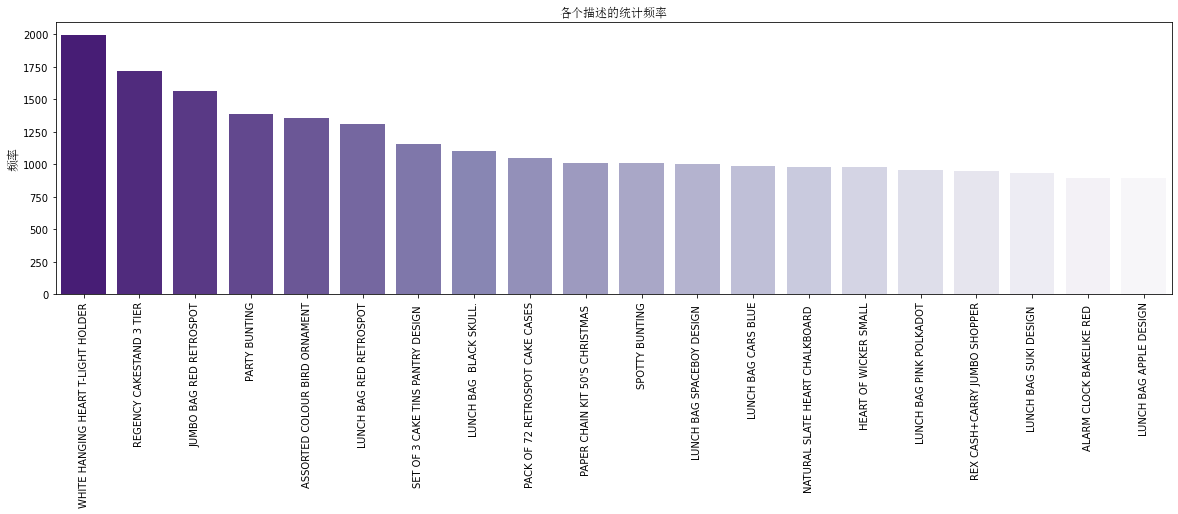

In [33]:
plt.figure(figsize=(20, 5))
description_frequency = df_cleaned["Description"].value_counts().sort_values(ascending=False)
sns.barplot(description_frequency.iloc[0:20].index, description_frequency.iloc[0:20].values, palette="Purples_r")
plt.ylabel("频率", fontproperties=font_set)
plt.title("各个描述的统计频率", fontproperties=font_set)
plt.xticks(rotation=90)

再仔细看一下Description的长度和除字母的统计情况

Text(0.5, 0, 'Description数字数量')

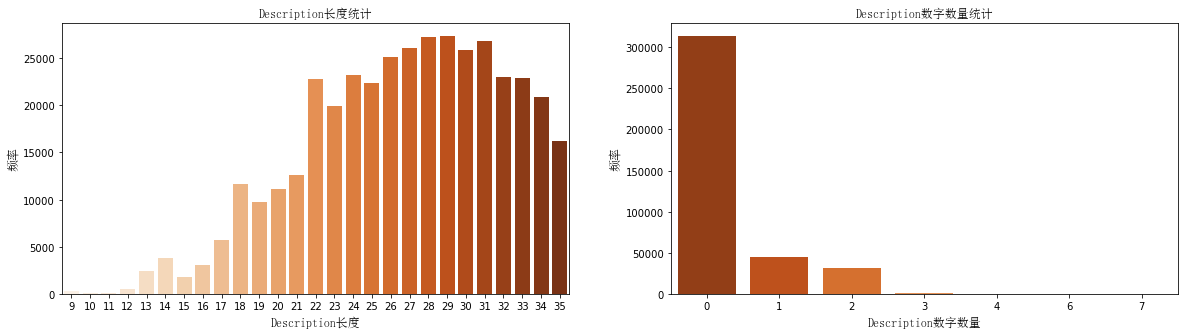

In [34]:
description_length = df_cleaned["Description"].apply(lambda l: len(l)).value_counts()
description_digits_length = df_cleaned["Description"].apply(lambda l: sum(1 for c in l if c.isdigit())).value_counts()
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.barplot(description_length.index, description_length.values, ax=ax[0], palette="Oranges")
ax[0].set_ylabel("频率", fontproperties=font_set)
ax[0].set_title("Description长度统计", fontproperties=font_set)
ax[0].set_xlabel("Description长度", fontproperties=font_set)
sns.barplot(description_digits_length.index, description_digits_length.values, palette="Oranges_r")
ax[1].set_ylabel("频率", fontproperties=font_set)
ax[1].set_title("Description数字数量统计", fontproperties=font_set)
ax[1].set_xlabel("Description数字数量", fontproperties=font_set)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'WICKER STAR '),
  Text(1, 0, 'BINGO SET'),
  Text(2, 0, 'PHOTO CUBE'),
  Text(3, 0, 'BUTTON BOX '),
  Text(4, 0, 'OWL DOORSTOP'),
  Text(5, 0, 'POLKADOT PEN'),
  Text(6, 0, 'SOMBRERO '),
  Text(7, 0, 'SKULLS TAPE'),
  Text(8, 0, 'DOGGY RUBBER'),
  Text(9, 0, 'SPACE OWL'),
  Text(10, 0, 'CHAMBRE HOOK'),
  Text(11, 0, 'FROG CANDLE'),
  Text(12, 0, 'SPACE FROG'),
  Text(13, 0, 'RAIN PONCHO '),
  Text(14, 0, 'GOLD WASHBAG'),
  Text(15, 0, 'CORDIAL JUG')])

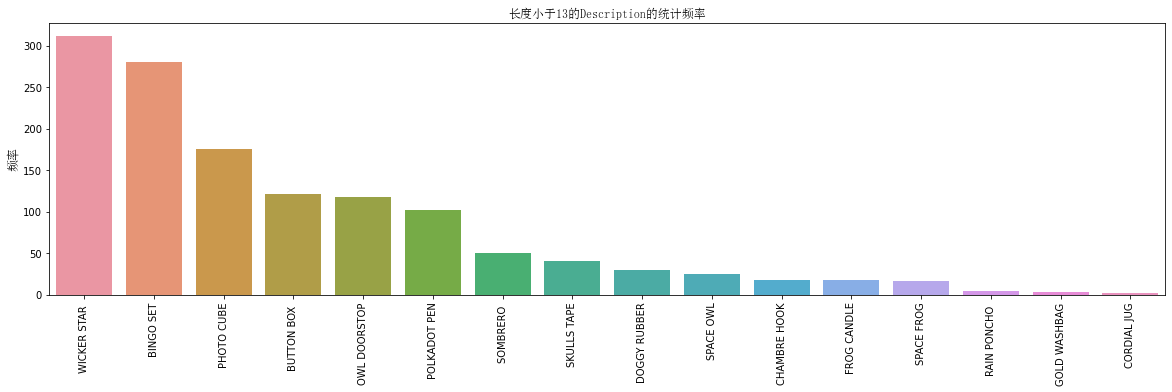

In [35]:
plt.figure(figsize=(20,5))
description_less14 = df_cleaned[df_cleaned["Description"].apply(lambda l: len(l) <= 12)].Description.value_counts().sort_values(ascending=False)

sns.barplot(description_less14.index, description_less14.values)
plt.ylabel("频率", fontproperties=font_set)
plt.title("长度小于13的Description的统计频率", fontproperties=font_set)
plt.xticks(rotation=90)

看上去，长度比较小的Description是没有问题，我们保留这些数据

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, "BOX OF 6 MINI 50'S CRACKERS"),
  Text(1, 0, "6 GIFT TAGS 50'S CHRISTMAS "),
  Text(2, 0, 'BAG 125g SWIRLY MARBLES'),
  Text(3, 0, '15CM CHRISTMAS GLASS BALL 20 LIGHTS'),
  Text(4, 0, 'BAG 250g SWIRLY MARBLES'),
  Text(5, 0, 'POLYESTER FILLER PAD 40x40cm'),
  Text(6, 0, "PACK OF 12 50'S CHRISTMAS TISSUES"),
  Text(7, 0, "3 RAFFIA RIBBONS 50'S CHRISTMAS "),
  Text(8, 0, 'POLYESTER FILLER PAD 45x45cm'),
  Text(9, 0, '200 RED + WHITE BENDY STRAWS'),
  Text(10, 0, 'BAG 500g SWIRLY MARBLES'),
  Text(11, 0, '200 BENDY SKULL STRAWS'),
  Text(12, 0, 'POLYESTER FILLER PAD 45x30cm'),
  Text(13, 0, 'POLYESTER FILLER PAD 30CMx30CM'),
  Text(14, 0, 'BLACK CHRISTMAS TREE 120CM'),
  Text(15, 0, 'PINK AND WHITE CHRISTMAS TREE 120CM'),
  Text(16, 0, '50CM METAL STRING WITH  7 CLIPS'),
  Text(17, 0, 'THE KING GIFT BAG 25x24x12cm'),
  Text(18, 0, 'PAPER LANTERN 9 POIN

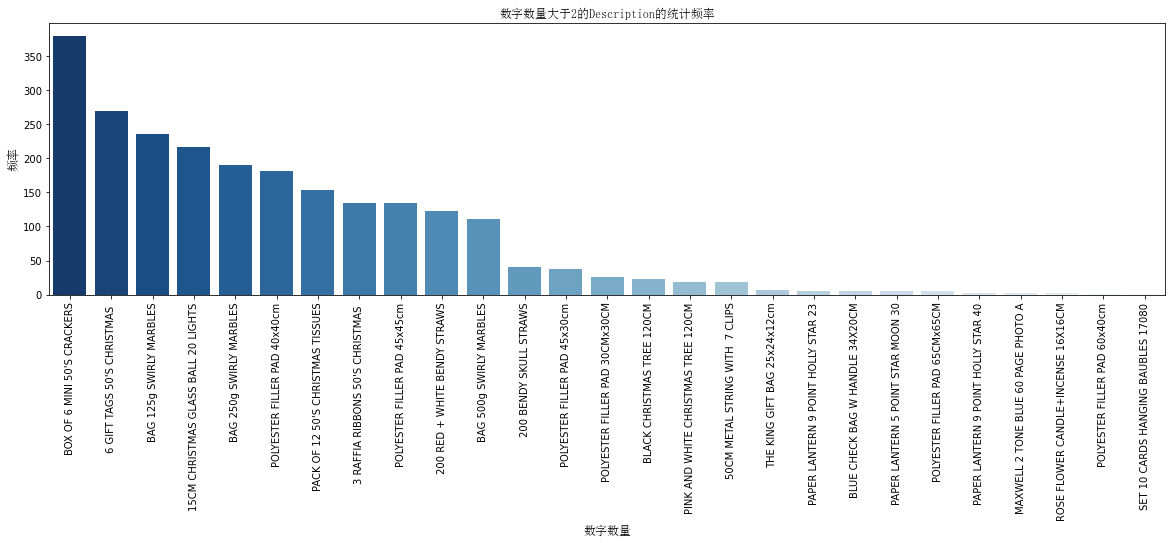

In [36]:
plt.figure(figsize=(20,5))
description_digit = df_cleaned[df_cleaned["Description"].apply(lambda l: sum(1 for c in l if c.isdigit()) in [3,4,5,6,7])].Description.value_counts().sort_values(ascending=False)

sns.barplot(description_digit.index, description_digit.values, palette="Blues_r")
plt.ylabel("频率", fontproperties=font_set)
plt.xlabel("数字数量", fontproperties=font_set)
plt.title("数字数量大于2的Description的统计频率", fontproperties=font_set)
plt.xticks(rotation=90)

看上去，数字数量多的的Description也是没有问题，我们不做处理

## 1.2 EDA
这部分主要对主要特征进行探索性分析。
### 1.2.1 用户角度

In [37]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


单个订单的用户占总用户数的 34.84%
2个订单的用户占总用户数的 19.29%
3个订单的用户占总用户数的 11.43%
3个订单以上的用户占总用户数的 34.44%
10个订单以上的用户占总用户数的 7.52%


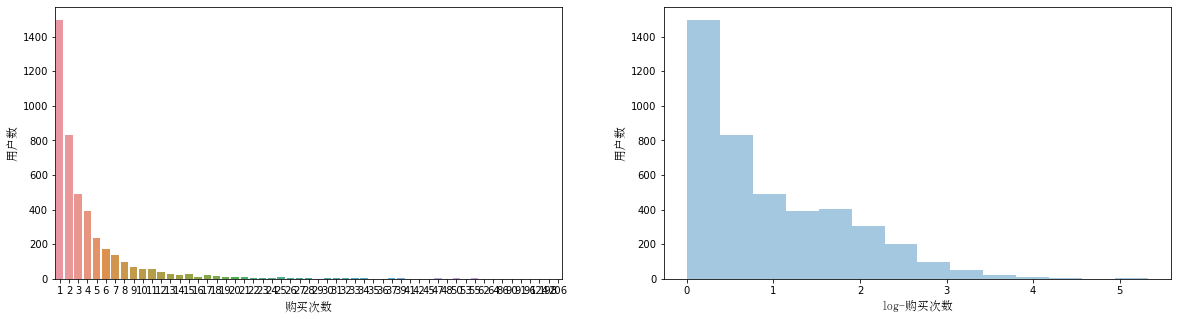

In [38]:
# 判断新老客户
InvoiceNo_each_customer = df_cleaned.groupby(["CustomerID"]).InvoiceNo.nunique()
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(InvoiceNo_each_customer.value_counts().index, InvoiceNo_each_customer.value_counts().values, ax=ax[0])
sns.distplot(np.log(InvoiceNo_each_customer.values), bins=14, kde=False, ax=ax[1])
ax[0].set_ylabel("用户数", fontproperties=font_set)
ax[0].set_xlabel("购买次数", fontproperties=font_set)
ax[1].set_ylabel("用户数", fontproperties=font_set)
ax[1].set_xlabel("log-购买次数", fontproperties=font_set)


print("单个订单的用户占总用户数的 {}%".format(round(sum(InvoiceNo_each_customer == 1) / InvoiceNo_each_customer.shape[0] * 100, 2)))
print("2个订单的用户占总用户数的 {}%".format(round(sum(InvoiceNo_each_customer == 2) / InvoiceNo_each_customer.shape[0] * 100, 2)))
print("3个订单的用户占总用户数的 {}%".format(round(sum(InvoiceNo_each_customer == 3) / InvoiceNo_each_customer.shape[0] * 100, 2)))
print("3个订单以上的用户占总用户数的 {}%".format(round(sum(InvoiceNo_each_customer > 3) / InvoiceNo_each_customer.shape[0] * 100, 2)))
print("10个订单以上的用户占总用户数的 {}%".format(round(sum(InvoiceNo_each_customer > 10) / InvoiceNo_each_customer.shape[0] * 100, 2)))

由此可见，产生单个订单的新用户占比为1/3。我们的利润主要来源于那2/3的用户，那如何把1/3的新用户尽量多的转化为我们2/3的老用户是我们利润提高的关键点。

由此我们可以为接下来预测模型定下一个目标：如何预测一个新用户第一次购买后是否会再次购买。这个指标是有实际意义的，如果我们知道一个新用户在第一次购买后很可能不会再购买，那我们可以针对这部分人采取不同的策略去提高再次购买的可能性，如给予特殊的优惠、第二次半价等。

### 1.2.2 商品角度

In [42]:
print("一共有", df_cleaned.StockCode.nunique(), "种商品")

一共有 3657 种商品


由于商品种类过多，把每种商品视为不同种的商品明显是不合理的，例如有些商品只有颜色的差异。因此接下来对商品进行分类。我这里采用了利用商品的Description，对description每一个词进行词根分析，产生一个key为词根，value为词的字典，并以value中最短的词代表这个词根。

